# The Object Detection Dataset



## Downloading the Dataset

In [1]:
%matplotlib inline
from d2l import torch as d2l
import torch
import torchvision
import os
import pandas as pd

d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip',
                           '5de26c8fce5ccdea9f91267273464dc968d20d72')

## Reading the Dataset

We are going to read the object detection dataset in the `read_data_bananas`
function. The dataset includes a csv file for target class labels and
ground truth bounding box coordinates in the `corner` format.
We define `BananasDataset` to create the `Dataset` instance and finally define
the `load_data_bananas` function to return the dataloaders.
There is no need to read the test dataset in random order.

In [2]:
def read_data_bananas(is_train=True):
    """Read the bananas dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                                    else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Since all images have same object class i.e. category '0',
        # the `label` column corresponds to the only object i.e. banana
        # The target is as follows : (`label`, `xmin`, `ymin`, `xmax`, `ymax`)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

def load_data_bananas(batch_size):
    """Load the bananas dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return (train_iter, val_iter)

Below, we read a minibatch and print the shape of the image and label. The shape of the image is the same as in the previous experiment (batch size, number of channels, height, width). The shape of the label is (batch size, $m$, 5), where $m$ is equal to the maximum number of bounding boxes contained in a single image in the dataset. Although computation for the minibatch is very efficient, it requires each image to contain the same number of bounding boxes so that they can be placed in the same batch. Since each image may have a different number of bounding boxes, we can add illegal bounding boxes to images that have less than $m$ bounding boxes until each image contains $m$ bounding boxes. Thus, we can read a minibatch of images each time. The label of each bunding box in the image is represented by a tensor of length 5. The first element in the tensor is the category of the object contained in the bounding box. When the value is -1, the bounding box is an illegal bounding box for filling purpose. The remaining four elements of the array represent the $x, y$ axis coordinates of the upper-left corner of the bounding box and the $x, y$ axis coordinates of the lower-right corner of the bounding box (the value range is between 0 and 1). The banana dataset here has only one bounding box per image, so $m=1$.

In [3]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

## Demonstration

We have ten images with bounding boxes on them. We can see that the angle, size, and position of banana are different in each image. Of course, this is a simple artificial dataset. In actual practice, the data are usually much more complicated.

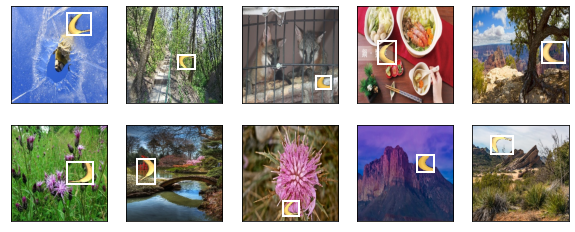

In [4]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## Summary

* The banana detection dataset we synthesized can be used to test object detection models.
* The data reading for object detection is similar to that for image classification. However, after we introduce bounding boxes, the label shape and image augmentation (e.g., random cropping) are changed.

## Exercises

1. Referring to the MXNet documentation, what are the parameters for the constructors of the `image.ImageDetIter` and `image.CreateDetAugmenter` classes? What is their significance?